# Carregamento de Dados

Objetivos dessa aula:
* Carregar dados reais do Pytorch
* Implementar o fluxo de treinamento completo de uma rede

Mas calma que essa ainda não é a linha de chegada. Ainda precisaremos falar do fluxo de validação.

## Hiperparâmetros

Agora que a brincadeira está ficando séria, que tal uma sugestão de como organizar o seu código? Para facilitar o entendimento e manutenção do código, mantenha sempre no início os seguintes elementos:
* imports de pacotes
* configuração de hiperparâmetros
* definição do hardware padrão utilizado

Nessa aula vamos trabalhar com dados reais, então **vamos precisar de GPU!** Então não se esqueça de mudar as configurações desse ambiente do colab. <br>
Sugiro rodar esse mesmo código sem GPU em outro momento, só pra sentir o gostinho de como a GPU facilitou o uso de redes neurais.

In [1]:
import torch
from torch import nn, optim

from torchvision import datasets
from torchvision import transforms 

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time

args = {
    'batch_size': 5,
    'num_workers': 4,
    'num_classes': 10,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'num_epochs': 30
}

if torch.cuda.is_available():
  args['device'] = torch.device('cuda')
else:
  args['device'] = torch.device('cpu')

print(args['device'])

cuda


## Datasets

O PyTorch possui dois pacotes que trazem datasets prontos para uso.

* Torchtext: https://torchtext.readthedocs.io/en/latest/datasets.html
* Torchvision: https://pytorch.org/docs/stable/torchvision/datasets.html

Como os nomes indicam, são datasets de textos (text) e imagens (vision), duas aplicações onde redes neurais são muito bem sucedidas.

Para aplicações com textos e outros tipos de séries temporais, o carregamento de dados possui nuances que dificultam o entendimento, portanto vamos concentrar no carregamento de imagens.

### Torchvision datasets

Para trabalhar com datasets do pacote torchvision, basta
* Importar o pacote
``` python 
from torchvision import datasets 
```
* Carregar o dataset do seu interesse (ex: MNIST)
``` python 
data = datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)
```

Documentação: https://pytorch.org/docs/stable/torchvision/datasets.html

### Torchvision transforms

Não vamos entrar em detalhes sobre transformações de imagens, mas para qualquer dataset é necessário transformá-lo em tensor para que possamos alimentar uma rede em pytorch. Isso pode ser feito no carregamento dos dados, basta:

* Importar o pacote transforms
``` python 
from torchvision import transforms 
```
* preencher o parâmetro ```tranform``` do dataset com a função que converte para tensor.
``` python 
transforms.ToTensor() 
```

Pronto! Quando seu dado for carregado, ele passará pela transformação indicada no parâmetro ```tranform```, nesse caso, convertendo o dado para um tensor.

Documentação: https://pytorch.org/docs/stable/torchvision/transforms.html


In [2]:
train_set = datasets.MNIST('./', 
                           train=True, 
                           transform=transforms.ToTensor(),
                           download=True)

test_set = datasets.MNIST('./', 
                           train=False, 
                           transform=transforms.ToTensor(),
                           download=False)

print('Amostras de treino: ' + str(len(train_set)) + '\nAmostras de Teste:' + str(len(test_set)))

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw

Amostras de treino: 60000
Amostras de Teste:10000


Cada dataset possui uma implementação específica internamente no pytorch. Verifique o ```type``` da variável que recebeu os dados e veja que se refere a uma classe específica do dataset.

No entanto, o item de qualquer dataset **sempre será uma tupla ```(dado, rótulo)```**. 

In [3]:
print(type(train_set))
print(type(train_set[0]))

<class 'torchvision.datasets.mnist.MNIST'>
<class 'tuple'>


Podemos então iterar no dataset para observar algumas amostras e seus rótulos.

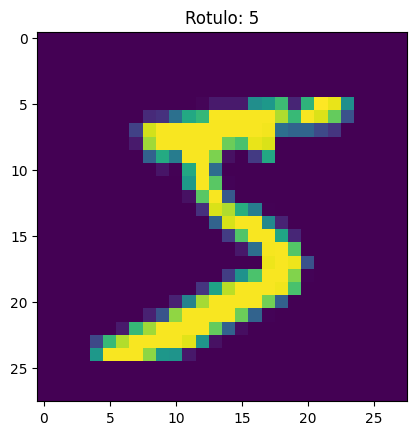

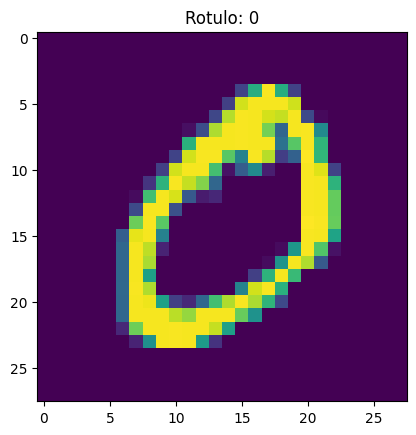

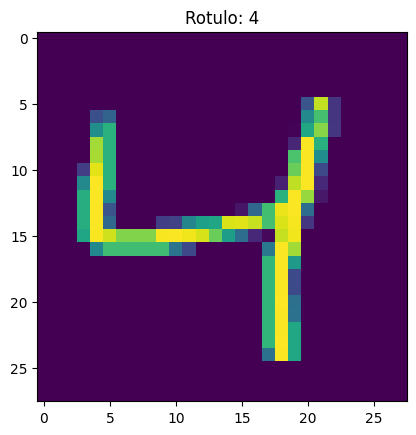

In [4]:
for i in range(3):
  dado, rotulo = train_set[i]

  plt.figure()
  plt.imshow(dado[0])
  plt.title('Rotulo: '+ str(rotulo))

Temos um total de 70 mil amostras, mas elas **ainda não estão carregadas na memória** (isso seria bastante custoso). A vantagem da classe ```Dataset``` do Pytorch é que as amostras só são carregadas quando necessário.

Sugestão: experimente trocar a transformação do Dataset para
```python
transforms.RandomCrop(12)
```
Essa função realiza um recorte aleatório de ```12 x 12``` (pixels) na imagem. Ao carregar a mesma amostra múltiplas vezes, um novo recorte será feito. 

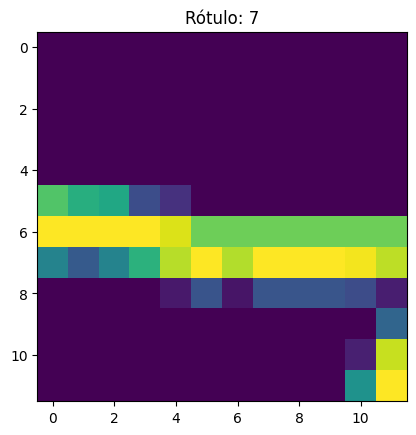

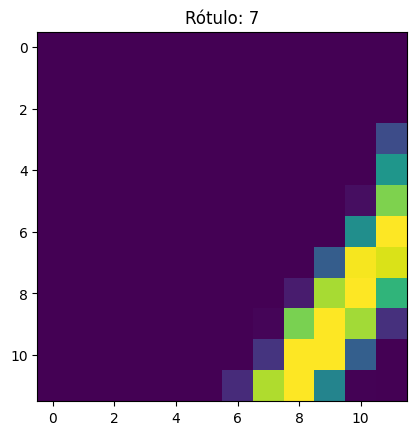

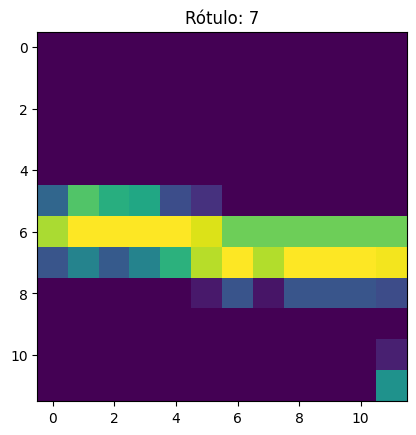

In [5]:
crop_set = datasets.MNIST('./', 
                           train=False, 
                           transform=transforms.RandomCrop(12),
                           download=False)

# Tuple (dado, rótulo)
for i in range(3):
  dado, rotulo = crop_set[0]
  
  plt.figure()
  plt.imshow(dado)
  plt.title('Rótulo: '+ str(rotulo))

Em resumo, cada vez que indexamos um item do dataset, as seguintes operações são realizadas:
* Amostra lida do arquivo e carregada como uma tupla ```(dado, rótulo)```
* As transformações são aplicadas 

## Dataloader

Essa aqui é uma das principais razões do Pytorch ser o pacote preferido de muitos profissionais. O Dataloader gerencia muito bem o carregamento de dados para o treinamento de redes neurais, trazendo as funções: 

* Separação dos dados em batches
* Embaralhando os dados
* Carregando batches em paralelo utilizando threads

O uso de threads no carregamento minimiza períodos ociosos de processamento, visto que a leitura de dados em arquivo é um grande gargalo de tempo.

As três funcionalidades que acabamos de conhecer são controladas pelos parâmetros da chamada do DataLoader.
```python
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
```


In [6]:
train_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

test_loader = DataLoader(test_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

O objeto retornado é um **iterador**, podendo ser utilizado para iterar em loops mas não suportando indexação.

torch.Size([5, 1, 28, 28]) torch.Size([5])


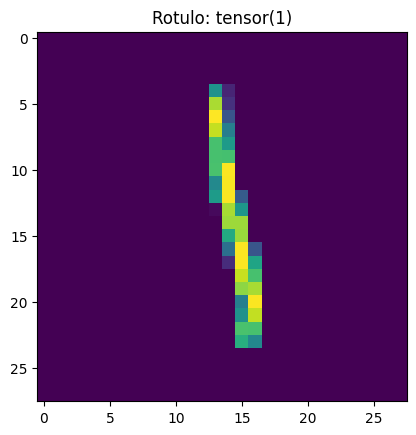

In [7]:
for batch in train_loader:
  
  dado, rotulo = batch
  print(dado.size(), rotulo.size())

  plt.imshow(dado[0][0])
  plt.title('Rotulo: '+ str(rotulo[0]) )
  break

## Implementando o MLP


**Lembrete**: Multi-Layer Perceptrons trabalham somente com dados unidimensionais (vetores). Sendo a imagem com dimensionalidade ```(1, 28, 28)```, precisamos linearizá-la antes de alimentar a rede. Isso implica que o a entrada da rede terá ```input_size = 28 x 28 x 1 = 784```

In [8]:
class MLP(nn.Module):

  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()

    self.features  = nn.Sequential(
                      nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size),
                      nn.ReLU()
                    )
    self.out     = nn.Linear(hidden_size, out_size)
    self.softmax = nn.Softmax()

  def forward(self, X):
    
    X = X.view(X.size(0), -1)

    feature = self.features(X)
    output  = self.softmax(self.out(feature))

    return output

input_size  = 28 * 28
hidden_size = 128
out_size    = 10 #classes

torch.manual_seed(42)
net = MLP(input_size, hidden_size, out_size).to(args['device']) #cast na GPU 

## Definindo loss e otimizador

In [9]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Fluxo de Treinamento

Agora vamos aplicar o conhecimento que acabamos de aprender!

Relembrando o passo a passo do fluxo de treinamento:
* Iterar nas épocas
* Iterar nos batches
* Cast dos dados no dispositivo de hardware
* Forward na rede e cálculo da loss
* Cálculo do gradiente e atualização dos pesos

Para acompanhar a convergência do seu modelo (e garantir que tudo foi feito certinho), ao final de cada época podemos imprimir a média e o desvio padrão das perdas de cada iteração.

In [10]:
for epoch in range(args['num_epochs']):
  start = time.time()

  epoch_loss = []
  for batch in train_loader:
    
    dado, rotulo = batch

    # Cast na GPU
    dado   = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # Forward 
    pred = net(dado)
    loss = criterion(pred, rotulo)
    epoch_loss.append(loss.cpu().data)

    # Backward
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  end = time.time()

  print("Epoca %d, Loss: %.4f +\- %.4f, Tempo: %.2f" % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start) )


<>:25: SyntaxWarning: invalid escape sequence '\-'
<>:25: SyntaxWarning: invalid escape sequence '\-'
C:\Users\mathe\AppData\Local\Temp\ipykernel_24684\278962469.py:25: SyntaxWarning: invalid escape sequence '\-'
  print("Epoca %d, Loss: %.4f +\- %.4f, Tempo: %.2f" % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start) )
C:\Users\mathe\anaconda3\envs\gpu2\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoca 0, Loss: 1.8282 +\- 0.2220, Tempo: 25.92
Epoca 1, Loss: 1.9606 +\- 0.2268, Tempo: 26.95
Epoca 2, Loss: 2.0282 +\- 0.2292, Tempo: 26.76
Epoca 3, Loss: 2.0771 +\- 0.2191, Tempo: 26.21
Epoca 4, Loss: 2.1672 +\- 0.2024, Tempo: 25.78
Epoca 5, Loss: 2.1889 +\- 0.2005, Tempo: 26.02
Epoca 6, Loss: 2.2065 +\- 0.1953, Tempo: 27.25
Epoca 7, Loss: 2.2424 +\- 0.1840, Tempo: 26.24
Epoca 8, Loss: 2.2669 +\- 0.1769, Tempo: 26.35
Epoca 9, Loss: 2.2758 +\- 0.1762, Tempo: 26.12
Epoca 10, Loss: 2.2790 +\- 0.1707, Tempo: 25.99
Epoca 11, Loss: 2.2799 +\- 0.1745, Tempo: 26.20
Epoca 12, Loss: 2.2807 +\- 0.1736, Tempo: 26.00
Epoca 13, Loss: 2.2811 +\- 0.1726, Tempo: 26.08
Epoca 14, Loss: 2.2815 +\- 0.1710, Tempo: 26.88
Epoca 15, Loss: 2.2820 +\- 0.1699, Tempo: 28.72
Epoca 16, Loss: 2.2823 +\- 0.1717, Tempo: 29.35
Epoca 17, Loss: 2.2826 +\- 0.1719, Tempo: 28.26
Epoca 18, Loss: 2.2829 +\- 0.1711, Tempo: 26.37
Epoca 19, Loss: 2.2832 +\- 0.1706, Tempo: 26.32
Epoca 20, Loss: 2.2833 +\- 0.1712, Tempo: 29.85
Ep

### Interpretando a qualidade do modelo

Apesar da loss ser o critério utilizado na otimização do modelo, seu valor é pouco interpretável por seres humanos.

* *A loss está melhorando, mas como saber se meu modelo está bom mesmo?*

Podemos calcular uma métrica mais interpretável. No caso da classificação, temos a acurácia como métrica mais simples de avaliação. Esse valor será usado exclusivamente para visualizar a qualidade do modelo, não interferindo no treinamento da rede. 

Na célula anterior utilizaremos a biblioteca Scikit-Learn para calcular a acurácia, para isso basta
* Armazenar os rótulos de cada iteração
* Calcular a predição a partir da saída da rede
* Utilizar a função do sklearn para cálculo da acurácia
```python
metrics.accuracy_score(rotulos, ypreds)
```

Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html